In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
hp = pd.read_csv('sp500_stocks_4.18.2024.csv', parse_dates=True, index_col='Date')
mshp = hp[hp['Symbol'] == 'MSFT']

In [3]:
# Select features and target
features = mshp[['Close', 'Volume']]
target = mshp['Close']

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)

In [4]:
X = []
y = []

n_future = 5  # Number of days we want to predict into the future
n_past = 14   # Number of past days we want to use to predict the future

for i in range(n_past, len(features_scaled) - n_future +1):
    X.append(features_scaled[i - n_past:i, 0:features_scaled.shape[1]])
    y.append(features_scaled[i + n_future - 1:i + n_future, 0])

X, y = np.array(X), np.array(y)
print("Shape of X:", X.shape)

Shape of X: (3578, 14, 2)


In [5]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, 2)))  # 14 timesteps, 2 features
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))

C:\Users\ericz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
split = int(X.shape[0]*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate and predict as before
predicted_stock_prices = model.predict(X_test)


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6038e-04 - val_loss: 4.8972e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2425e-04 - val_loss: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3702e-04 - val_loss: 4.4093e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7556e-05 - val_loss: 4.2958e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1672e-04 - val_loss: 7.4609e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3266e-05 - val_loss: 4.1123e-04
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4097e-05 - val_loss: 5.3600e-04
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5039e-05 - val_loss: 4.1017e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1059e-05 - val_loss: 6.1219e-04
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4090e-05 - val_loss: 3.9713e-0

In [8]:
# Create a dummy array for the 'Volume' with the same number of rows as your predictions
dummy_volume = np.zeros((predicted_stock_prices.shape[0], 1))

# Concatenate your predictions with this dummy array to match the original feature structure
predicted_full = np.hstack([predicted_stock_prices, dummy_volume])

# Now perform the inverse transformation
predicted_prices_original_scale = scaler.inverse_transform(predicted_full)[:, 0]  # Select only the 'Close' prices


In [9]:
# Assuming y_test is your actual prices and also needs reshaping to match the scaler's original fit
actual_prices_full = np.hstack([y_test.reshape(-1, 1), dummy_volume])  # Use the same dummy column as above
actual_prices_original_scale = scaler.inverse_transform(actual_prices_full)[:, 0]  # Select only the 'Close' prices


In [10]:
# Calculate performance metrics, e.g., RMSEfrom sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actual_prices_original_scale, predicted_prices_original_scale))
print('Test RMSE:', rmse)


Test RMSE: 13.569570706919345


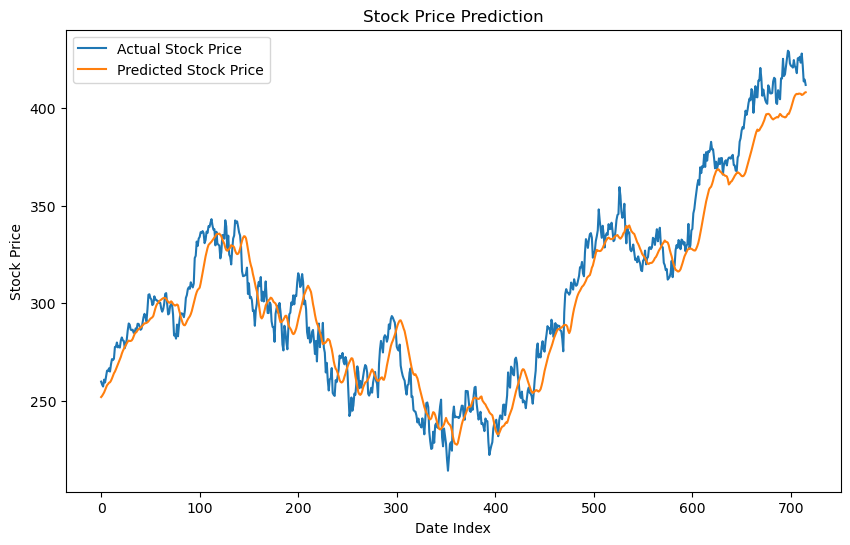

In [11]:
# Assuming 'actual_prices' is your actual stock prices from the test set that have been inverse transformed if necessary

plt.figure(figsize=(10, 6))
plt.plot(actual_prices_original_scale, label='Actual Stock Price')
plt.plot(predicted_prices_original_scale, label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()